# PD2
## Piotr Fic
## Biblioteki i funkcje pomocnicze

In [2]:
import numpy as np
from numpy import random
import math
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
def predicted_real(predicted, real):
    plt.scatter(real, predicted, c='blue')
    p1 = max(max(predicted), max(real))
    p2 = min(min(predicted), min(real))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True values')
    plt.ylabel('Predictions')
    plt.title('Predictions visualization on test set')
    plt.axis('equal')
    plt.show()
    
def sigmoid(x):
    "Stabilna funkcja sigmoidalna"""
    if x >= 0:
        z = np.exp(-x)
        return 1 / (1 + z)
    else:
        z = np.exp(x)
        return z / (1 + z)
sigmoid = np.vectorize(sigmoid)

def sigmoid_der(x):
    """Pochodna funkcji sigmoidalnej"""
    return sigmoid(x)*(1-sigmoid(x))
sigmoid_der = np.vectorize(sigmoid_der)

def MSE(predicted, real):
    return np.mean((predicted - real)**2)

def MAE(predicted, real):
    return np.mean(np.abs(predicted - real))

def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

def prepear_data(df_train, df_test):
    #Separacja wektorów cech i odpowiedzi
    x_train, x_test = df_train.iloc[:, 1], df_test.iloc[:, 1]
    x_train, x_test = np.array(x_train), np.array(x_test)
    #Implementacja wymaga "pionowego" wektora cech
    x_train.shape = (len(x_train), 1)
    x_test.shape = (len(x_test), 1)
    y_train, y_test = np.array(df_train.iloc[:, 2:3]), np.array(df_test.iloc[:, 2:3])
    #Normalizacja
    x_train, x_test = normalize(x_train), normalize(x_test)
    y_train, y_test = normalize(y_train), normalize(y_test)
    return x_train, y_train, x_test, y_test

## Implementacja MLP rozbudowana o metody uczące

In [19]:
class Layer:
        
    def __init__(self, 
                 #Liczba neuronów w poprzedzającej i kolejnej warstwie
                 input_size: int, 
                 output_size: int,
                 #Domyślna funkcja aktywacyjna i jej pochodna                 
                 activation_fun = sigmoid, 
                 activation_fun_der = sigmoid_der,
                 #Parametry rozkładu jednostajnego dla losowych wag
                 lb = -1,
                 ub = 1,
                 #Możliwe do ustawienia wagi i bias-y
                 weights = None, 
                 biases = None):
        
        #Domyślne losowo wygenerowane wagi i bias-y jeśli nie zostały podane
        d_weights = random.uniform(lb, ub, size = (input_size, output_size))
        d_biases = random.uniform(lb, ub, size = (1, output_size))
        
        #Wagi dla wszystkich neuronów z warstwy 
        self.weights = weights if weights is not None else d_weights
        
        #Stałe "b"
        self.biases = biases if biases is not None else d_biases
        
        #Funkcja aktywacji i jej pochodna
        self.activation_fun = activation_fun
        self.activation_fun_der = activation_fun_der
    
    def predict(self, input):
        #Przekształca input z poprzedniej warstwy przez wagi i funkcję aktywacji 
        #Zwraca output do przekazania kolejnej warstwie
        return self.activation_fun(input @ self.weights + self.biases)
    
    def forward(self, input):
        #Przekształca input z poprzedniej warstwy jedynie przez wagi
        return input @ self.weights + self.biases

In [20]:
class Network:
    
    def __init__(self, layers: list):
        
        #Warstwy
        self.layers = layers
        
    def predict(self, X):
        """Oblicza output na podstawie danych i parametrów warstw"""
        output = X
        for layer in self.layers:
            output = layer.predict(output)
        return output
    
    def forward(self, X):
        """Pełna metoda feedforward
        return: sumy, aktywacje"""
        sums = []
        activations = [X]
        activations_layer = X
        for layer in self.layers:
            sums_layer = layer.forward(activations_layer)
            sums.append(sums_layer)
            
            activations_layer = layer.activation_fun(sums_layer)
            activations.append(activations_layer)
            
        return sums, activations
    
    def backprop(self, X, Y):
        """Propagacja wsteczna błędu
        return: gradienty MSE"""
        
        #Wyliczenie feedforward obecnymi parametrami
        sums, activations = self.forward(X)
        
        #Macierze na poprawki parametrów
        delta_biases = [np.zeros(l.biases.shape) for l in self.layers]
        delta_weights = [np.zeros(l.weights.shape) for l in self.layers]
        
        #Wyliczenie err ostatniej warstwy
        err = (activations[-1] - Y)*self.layers[-1].activation_fun_der(sums[-1])
        
        #Wyliczenie gradientu MSE po parametrach ostatniej warstwy
        delta_biases[-1] = err
        delta_weights[-1] = activations[-2].transpose()@err
        
        #Propagacja wsteczna
        n_layers = len(self.layers)
        
        for i in range(n_layers-2, -1, -1):
            act_f_der = self.layers[i].activation_fun_der(sums[i])
            err = (err@self.layers[i+1].weights.transpose()) * act_f_der 
            delta_biases[i] = err
            delta_weights[i] = np.dot(activations[i-1].transpose(), err)
        
        return delta_biases, delta_weights
    
    def train(self, X, Y, k = 1, etha = 0.001, tol = 10**(-6), n_iter = 500, verbose = False):
        """Wytrenowuje sieć wybraną metodą minimalizując MSE 
        na zbiorze walidacyjnym
        return: liczba epok (na potrzeby porównań)"""
        
        etha = etha/len(X)
        
        if(k==1):
            algorithm = self.gd
        else:
            algorithm = self.batch_gd
        
        #Losowość przed podziałem zbioru, ziarno zapewnia identyczną permutację
        #w zmiennych objaśnających i zmiennej celu
        random.RandomState(42).shuffle(X)
        random.RandomState(42).shuffle(Y)
        
        #Podział zbioru na część walidacyjną i treningową
        #proporcje: val 20% - train 80%
        X_split = np.split(X, [int(.8 * len(X))])
        X_train, X_val = X_split[0], X_split[1]
        
        Y_split = np.split(Y, [int(.8 * len(Y))])
        Y_train, Y_val = Y_split[0], Y_split[1]
        
        #Właściwe trenowanie sieci
        current_mse = np.inf
        new_mse = MSE(self.predict(X_val), Y_val)
        it = 1
        while True:
            #Wywołanie konkretnego algorytmu
            algorithm(X_train, Y_train, k, etha)
            new_mse = MSE(self.predict(X_val), Y_val)
            
            #Wizualizacja procesu uczenia
            if(verbose):
                print("Epoche " + str(it) + " finished")
                print("Current MSE on validation set:")
                print(new_mse)
                for i in range(len(self.layers)):
                    print("Warstwa " + str(i) + " wagi:")
                    print(self.layers[i].weights)
                    print("Warstwa " + str(i) + " bias-y:")
                    print(self.layers[i].biases)
                print("\n")
            
            it += 1
            if(it == n_iter):
                break
            elif(current_mse - new_mse > tol):
                current_mse = new_mse
            else:
                break
            
        return it
    
    def gd(self, X, Y, k, etha):
        """Trening sieci podstawową metodą Gradient Descent"""
        delta_biases = [np.zeros(l.biases.shape) for l in self.layers]
        delta_weights = [np.zeros(l.weights.shape) for l in self.layers]
        
        for x, y in zip(X, Y):
            b, w = self.backprop(x, y)
            delta_biases = [cb-etha*nb for cb, nb in zip(delta_biases, b)]
            delta_weights = [cw-etha*nw for cw, nw in zip(delta_weights, w)]
        
        for i in range(len(self.layers)):
            l = self.layers[i]
            l.biases = l.biases + delta_biases[i]
            l.weights = l.weights + delta_weights[i]
        return
    
    def batch_gd(self, X, Y, k, etha):
        """Trening sieci metodą Mini-batch Gradient Descent"""
        #Metoda train uprzednio dokonuje permutacji zbioru
        #Wystarczy podzielić go na batche
        X_split = np.array_split(X, k)
        Y_split = np.array_split(Y, k)
        
        #Wywołanie metody gradient descent na kolejnych batch-ach
        for i in range(k):
            self.gd(X_split[i], Y_split[i], k, etha)
        return
        

### Wczytanie danych

In [6]:
df1_train = pd.read_csv("./mio1/regression/square-simple-training.csv")
df1_test = pd.read_csv("./mio1/regression/square-simple-test.csv")

df2_train = pd.read_csv("./mio1/regression/steps-small-training.csv")
df2_test = pd.read_csv("./mio1/regression/steps-small-test.csv")

df3_train = pd.read_csv("./mio1/regression/multimodal-large-training.csv")
df3_test = pd.read_csv("./mio1/regression/multimodal-large-test.csv")

### Przygotowanie architektur

In [21]:
#Te same koncepcje co w PD1
#Architektura 1
def arch1(lb = -1, ub = 1):
    l1_1 = Layer(input_size=1, output_size=5, lb = -1, ub = 1)
    l1_2 = Layer(input_size=5, output_size=1, lb = -1, ub = 1, 
               activation_fun= lambda x: x, 
               activation_fun_der= lambda x: 1)          
    return Network([l1_1, l1_2])
    
#Architektura 2
def arch2(lb = -1, ub = 1):
    l2_1 = Layer(1, 10, lb = -1, ub = 1)
    l2_2 = Layer(10, 1, lb = -1, ub = 1, 
                 activation_fun= lambda x: x, 
                 activation_fun_der= lambda x: 1)
    return Network([l2_1, l2_2])

#Architektura 3
def arch3(lb = -1, ub = 1):
    l3_1 = Layer(input_size=1, output_size=5, lb = -1, ub = 1)
    l3_2 = Layer(input_size=5, output_size=5, lb = -1, ub = 1)
    l3_3 = Layer(input_size=5, output_size=1, lb = -1, ub = 1,
               activation_fun= lambda x: x, 
               activation_fun_der= lambda x: 1)
    return Network([l3_1, l3_2, l3_3])

# Test na zbiorze multimodal-large
Jest to zbiór o dużej liczbie obserwacji, przetestuję wstępnie na nim trenowanie sieci. Do eksperymentów użyję dwóch mniejszych ze względu na czas obliczeń.

In [46]:
x_train, y_train, x_test, y_test = prepear_data(df3_train, df3_test)
mlp = arch1()
mlp.train(x_train, y_train, etha=5**(-2), verbose=True)

Epoche 1 finished
Current MSE on validation set:
0.28943428700154356
Warstwa 0 wagi:
[[-0.84018542 -0.82283186 -0.9677817  -0.67544709  0.74068181]]
Warstwa 0 bias-y:
[[-0.34839154  0.07313773  0.46407111 -0.6489159  -0.72415872]]
Warstwa 1 wagi:
[[-0.93754477]
 [-0.39591346]
 [-0.59875451]
 [-0.13394969]
 [ 0.34714576]]
Warstwa 1 bias-y:
[[0.58382763]]


Epoche 2 finished
Current MSE on validation set:
0.2621635010858524
Warstwa 0 wagi:
[[-0.84008875 -0.82279435 -0.96773294 -0.67543443  0.74066055]]
Warstwa 0 bias-y:
[[-0.35148178  0.071652    0.46174361 -0.64932151 -0.72281896]]
Warstwa 1 wagi:
[[-0.93278215]
 [-0.38962097]
 [-0.59129653]
 [-0.12983458]
 [ 0.35401426]]
Warstwa 1 bias-y:
[[0.5997087]]


Epoche 3 finished
Current MSE on validation set:
0.23803850116072817
Warstwa 0 wagi:
[[-0.8400915  -0.82280378 -0.96775675 -0.67543482  0.74068117]]
Warstwa 0 bias-y:
[[-0.35436696  0.07027692  0.45957955 -0.6496908  -0.72153085]]
Warstwa 1 wagi:
[[-0.92832651]
 [-0.38372235]
 [-0.5843

Epoche 24 finished
Current MSE on validation set:
0.06649311801234728
Warstwa 0 wagi:
[[-0.8469353  -0.82592347 -0.97295632 -0.67613238  0.74479186]]
Warstwa 0 bias-y:
[[-0.38565352  0.05602778  0.4363336  -0.65307511 -0.70445322]]
Warstwa 1 wagi:
[[-0.88029557]
 [-0.31889144]
 [-0.50777256]
 [-0.08344428]
 [ 0.439805  ]]
Warstwa 1 bias-y:
[[0.78895276]]


Epoche 25 finished
Current MSE on validation set:
0.06482591219652538
Warstwa 0 wagi:
[[-0.84726779 -0.82606909 -0.97320394 -0.67616192  0.74501427]]
Warstwa 0 bias-y:
[[-0.38630636  0.05573567  0.43583003 -0.65313313 -0.70399591]]
Warstwa 1 wagi:
[[-0.87935213]
 [-0.31756346]
 [-0.50621548]
 [-0.08257167]
 [ 0.44185686]]
Warstwa 1 bias-y:
[[0.79305677]]


Epoche 26 finished
Current MSE on validation set:
0.06334681624287186
Warstwa 0 wagi:
[[-0.84759197 -0.82621098 -0.97344577 -0.67619047  0.74523352]]
Warstwa 0 bias-y:
[[-0.38691567  0.05546214  0.43535636 -0.65318682 -0.70356067]]
Warstwa 1 wagi:
[[-0.87848055]
 [-0.31633041]
 [-0

Epoche 48 finished
Current MSE on validation set:
0.052251503968233706
Warstwa 0 wagi:
[[-0.8529114  -0.8285611  -0.97753998 -0.67663427  0.74923399]]
Warstwa 0 bias-y:
[[-0.3933031   0.05235768  0.42967379 -0.65372846 -0.69776407]]
Warstwa 1 wagi:
[[-0.87098865]
 [-0.30468755]
 [-0.49130545]
 [-0.07413661]
 [ 0.47139623]]
Warstwa 1 bias-y:
[[0.84492868]]


Epoche 49 finished
Current MSE on validation set:
0.052129993074927786
Warstwa 0 wagi:
[[-0.85309159 -0.82864267 -0.97768531 -0.67664887  0.74938521]]
Warstwa 0 bias-y:
[[-0.39339792  0.05229582  0.42954565 -0.65373653 -0.69761136]]
Warstwa 1 wagi:
[[-0.87097554]
 [-0.30459351]
 [-0.49120785]
 [-0.07407696]
 [ 0.47221169]]
Warstwa 1 bias-y:
[[0.84605908]]


Epoche 50 finished
Current MSE on validation set:
0.05201829315894794
Warstwa 0 wagi:
[[-0.85326822 -0.82872284 -0.97782833 -0.67666317  0.74953456]]
Warstwa 0 bias-y:
[[-0.3934829   0.05223789  0.42942398 -0.65374382 -0.69746448]]
Warstwa 1 wagi:
[[-0.87097895]
 [-0.3045215 ]
 [

Epoche 71 finished
Current MSE on validation set:
0.05070174833467818
Warstwa 0 wagi:
[[-0.85642029 -0.83018858 -0.98047317 -0.67692027  0.75237671]]
Warstwa 0 bias-y:
[[-0.39377547  0.05161245  0.42784915 -0.65377889 -0.69527671]]
Warstwa 1 wagi:
[[-0.87355115]
 [-0.30634302]
 [-0.49357165]
 [-0.07528382]
 [ 0.48624541]]
Warstwa 1 bias-y:
[[0.86162788]]


Epoche 72 finished
Current MSE on validation set:
0.050658314113518274
Warstwa 0 wagi:
[[-0.85655336 -0.83025188 -0.98058832 -0.67693129  0.75250315]]
Warstwa 0 bias-y:
[[-0.3937445   0.05160044  0.42780364 -0.65377699 -0.69519986]]
Warstwa 1 wagi:
[[-0.87374853]
 [-0.30652967]
 [-0.49380569]
 [-0.07540933]
 [ 0.48677236]]
Warstwa 1 bias-y:
[[0.8620728]]


Epoche 73 finished
Current MSE on validation set:
0.050615382963097984
Warstwa 0 wagi:
[[-0.85668551 -0.83031484 -0.98070289 -0.67694225  0.75262912]]
Warstwa 0 bias-y:
[[-0.39371109  0.05158939  0.42775974 -0.65377489 -0.69512452]]
Warstwa 1 wagi:
[[-0.87394995]
 [-0.30672172]
 [-

Epoche 95 finished
Current MSE on validation set:
0.04972340497355651
Warstwa 0 wagi:
[[-0.85944756 -0.83164967 -0.98313682 -0.67717628  0.75533328]]
Warstwa 0 bias-y:
[[-0.39257492  0.05150615  0.42705852 -0.65369504 -0.69371433]]
Warstwa 1 wagi:
[[-0.879035  ]
 [-0.31181977]
 [-0.50036833]
 [-0.07895146]
 [ 0.49781279]]
Warstwa 1 bias-y:
[[0.86979418]]


Epoche 96 finished
Current MSE on validation set:
0.04968367481032239
Warstwa 0 wagi:
[[-0.85956933 -0.8317092  -0.98324536 -0.67718683  0.75545476]]
Warstwa 0 bias-y:
[[-0.39251194  0.05150691  0.42703417 -0.6536904  -0.69365722]]
Warstwa 1 wagi:
[[-0.87928421]
 [-0.31207564]
 [-0.50068433]
 [-0.07912241]
 [ 0.4982635 ]]
Warstwa 1 bias-y:
[[0.87006286]]


Epoche 97 finished
Current MSE on validation set:
0.049643961432029586
Warstwa 0 wagi:
[[-0.85969093 -0.83176869 -0.98335383 -0.67719739  0.75557621]]
Warstwa 0 bias-y:
[[-0.39244838  0.05150792  0.42701021 -0.6536857  -0.69360047]]
Warstwa 1 wagi:
[[-0.8795343 ]
 [-0.31233269]
 [-

Epoche 119 finished
Current MSE on validation set:
0.0487730275892725
Warstwa 0 wagi:
[[-0.8623471  -0.83307796 -0.98573624 -0.67743331  0.75825368]]
Warstwa 0 bias-y:
[[-0.39095494  0.05156924  0.42654767 -0.6535722  -0.6924094 ]]
Warstwa 1 wagi:
[[-0.88517356]
 [-0.31817165]
 [-0.50820479]
 [-0.08318999]
 [ 0.50834299]]
Warstwa 1 bias-y:
[[0.87562714]]


Epoche 120 finished
Current MSE on validation set:
0.0487335614366651
Warstwa 0 wagi:
[[-0.86246764 -0.83313776 -0.98584479 -0.67744425  0.75837603]]
Warstwa 0 bias-y:
[[-0.39088435  0.05157317  0.42652851 -0.65356671 -0.69235686]]
Warstwa 1 wagi:
[[-0.8854334 ]
 [-0.31844178]
 [-0.50853792]
 [-0.08337004]
 [ 0.5087729 ]]
Warstwa 1 bias-y:
[[0.87585219]]


Epoche 121 finished
Current MSE on validation set:
0.048694107773797714
Warstwa 0 wagi:
[[-0.8625882  -0.83319761 -0.9859534  -0.67745522  0.75849847]]
Warstwa 0 bias-y:
[[-0.39081363  0.05157716  0.42650946 -0.65356119 -0.6923044 ]]
Warstwa 1 wagi:
[[-0.88569339]
 [-0.3187121 ]
 [

Epoche 142 finished
Current MSE on validation set:
0.04786893216727917
Warstwa 0 wagi:
[[-0.86512952 -0.83446581 -0.9882483  -0.67769128  0.7610905 ]]
Warstwa 0 bias-y:
[[-0.38930701  0.05167089  0.42612546 -0.65344125 -0.69121415]]
Warstwa 1 wagi:
[[-0.89116859]
 [-0.32441035]
 [-0.51590042]
 [-0.08734473]
 [ 0.51813744]]
Warstwa 1 bias-y:
[[0.88064377]]


Epoche 143 finished
Current MSE on validation set:
0.04782981553302467
Warstwa 0 wagi:
[[-0.86525113 -0.8345268  -0.98835835 -0.6777028   0.76121501]]
Warstwa 0 bias-y:
[[-0.38923461  0.05167568  0.4261077  -0.65343537 -0.69116256]]
Warstwa 1 wagi:
[[-0.89142945]
 [-0.32468192]
 [-0.51623554]
 [-0.08752542]
 [ 0.51855977]]
Warstwa 1 bias-y:
[[0.8808565]]


Epoche 144 finished
Current MSE on validation set:
0.04779071626816169
Warstwa 0 wagi:
[[-0.86537281 -0.83458785 -0.98846848 -0.67771435  0.76133963]]
Warstwa 0 bias-y:
[[-0.38916217  0.05168049  0.42608998 -0.65342949 -0.69111098]]
Warstwa 1 wagi:
[[-0.89169028]
 [-0.32495346]
 [

Epoche 165 finished
Current MSE on validation set:
0.046973807420984455
Warstwa 0 wagi:
[[-0.86794355 -0.83588375 -0.99079929 -0.67796323  0.76398096]]
Warstwa 0 bias-y:
[[-0.38763502  0.05178523  0.42572385 -0.65330314 -0.69002972]]
Warstwa 1 wagi:
[[-0.89715745]
 [-0.3306429 ]
 [-0.52359559]
 [-0.0914882 ]
 [ 0.5277973 ]]
Warstwa 1 bias-y:
[[0.88547206]]


Epoche 166 finished
Current MSE on validation set:
0.04693511153947676
Warstwa 0 wagi:
[[-0.86806673 -0.83594613 -0.99091116 -0.67797538  0.76410791]]
Warstwa 0 bias-y:
[[-0.38756211  0.05179036  0.42570664 -0.653297   -0.68997827]]
Warstwa 1 wagi:
[[-0.89741715]
 [-0.33091302]
 [-0.5239293 ]
 [-0.09166761]
 [ 0.52821497]]
Warstwa 1 bias-y:
[[0.88567946]]


Epoche 167 finished
Current MSE on validation set:
0.046896434624995466
Warstwa 0 wagi:
[[-0.86818999 -0.83600857 -0.99102311 -0.67798756  0.76423498]]
Warstwa 0 bias-y:
[[-0.38748919  0.0517955   0.42568945 -0.65329085 -0.68992682]]
Warstwa 1 wagi:
[[-0.89767678]
 [-0.33118305]

Epoche 188 finished
Current MSE on validation set:
0.046088649128260745
Warstwa 0 wagi:
[[-0.87079497 -0.8373341  -0.99339289 -0.67824976  0.76692813]]
Warstwa 0 bias-y:
[[-0.38595586  0.05190556  0.42533209 -0.65315947 -0.68884618]]
Warstwa 1 wagi:
[[-0.90311217]
 [-0.33683234]
 [-0.5312466 ]
 [-0.095596  ]
 [ 0.53735977]]
Warstwa 1 bias-y:
[[0.89020114]]


Epoche 189 finished
Current MSE on validation set:
0.04605039582777783
Warstwa 0 wagi:
[[-0.87091981 -0.8373979  -0.99350663 -0.67826255  0.76705756]]
Warstwa 0 bias-y:
[[-0.38588278  0.0519109   0.42531523 -0.65315311 -0.68879471]]
Warstwa 1 wagi:
[[-0.90337016]
 [-0.33710029]
 [-0.53157803]
 [-0.09577368]
 [ 0.5377735 ]]
Warstwa 1 bias-y:
[[0.89040493]]


Epoche 190 finished
Current MSE on validation set:
0.046012161981489594
Warstwa 0 wagi:
[[-0.87104472 -0.83746176 -0.99362045 -0.67827537  0.76718709]]
Warstwa 0 bias-y:
[[-0.38580969  0.05191624  0.42529839 -0.65314673 -0.68874323]]
Warstwa 1 wagi:
[[-0.90362807]
 [-0.33736814]

Epoche 211 finished
Current MSE on validation set:
0.04521376352947828
Warstwa 0 wagi:
[[-0.87368421 -0.83881699 -0.99602921 -0.67855095  0.76993181]]
Warstwa 0 bias-y:
[[-0.38427394  0.05203021  0.42494775 -0.6530108  -0.68766169]]
Warstwa 1 wagi:
[[-0.90902556]
 [-0.34296948]
 [-0.53884238]
 [-0.09966213]
 [ 0.54683389]]
Warstwa 1 bias-y:
[[0.8948531]]


Epoche 212 finished
Current MSE on validation set:
0.0451759601726363
Warstwa 0 wagi:
[[-0.87381068 -0.8388822  -0.99614478 -0.67856437  0.77006367]]
Warstwa 0 bias-y:
[[-0.38420077  0.05203572  0.4249312  -0.65300423 -0.68761017]]
Warstwa 1 wagi:
[[-0.90928168]
 [-0.34323508]
 [-0.53917132]
 [-0.09983794]
 [ 0.54724385]]
Warstwa 1 bias-y:
[[0.89505372]]


Epoche 213 finished
Current MSE on validation set:
0.04513817647652038
Warstwa 0 wagi:
[[-0.87393721 -0.83894746 -0.99626044 -0.67857783  0.77019563]]
Warstwa 0 bias-y:
[[-0.3841276   0.05204123  0.42491466 -0.65299764 -0.68755865]]
Warstwa 1 wagi:
[[-0.90953773]
 [-0.34350057]
 [-

Epoche 234 finished
Current MSE on validation set:
0.04434927223147577
Warstwa 0 wagi:
[[-0.87661036 -0.84033194 -0.99870738 -0.67886673  0.77299091]]
Warstwa 0 bias-y:
[[-0.38259054  0.05215876  0.42457046 -0.65285741 -0.68647642]]
Warstwa 1 wagi:
[[-0.91489555]
 [-0.34905195]
 [-0.54637996]
 [-0.1036851 ]
 [ 0.55622169]]
Warstwa 1 bias-y:
[[0.89943346]]


Epoche 235 finished
Current MSE on validation set:
0.04431192272671259
Warstwa 0 wagi:
[[-0.8767384  -0.84039852 -0.99882476 -0.67888079  0.77312515]]
Warstwa 0 bias-y:
[[-0.38251733  0.05216444  0.42455421 -0.65285063 -0.68642488]]
Warstwa 1 wagi:
[[-0.91514977]
 [-0.34931516]
 [-0.54670635]
 [-0.10385902]
 [ 0.5566279 ]]
Warstwa 1 bias-y:
[[0.89963101]]


Epoche 236 finished
Current MSE on validation set:
0.04427459302989474
Warstwa 0 wagi:
[[-0.87686651 -0.84046516 -0.99894221 -0.67889488  0.77325949]]
Warstwa 0 bias-y:
[[-0.38244411  0.05217012  0.42453798 -0.65284385 -0.68637334]]
Warstwa 1 wagi:
[[-0.91540391]
 [-0.34957825]
 

Epoche 257 finished
Current MSE on validation set:
0.04349525590919836
Warstwa 0 wagi:
[[-0.87957212 -0.84187828 -1.00142632 -0.679197    0.77610408]]
Warstwa 0 bias-y:
[[-0.38090622  0.05229114  0.42420035 -0.6526995  -0.68529105]]
Warstwa 1 wagi:
[[-0.92072137]
 [-0.3550791 ]
 [-0.55385834]
 [-0.10766455]
 [ 0.56552344]]
Warstwa 1 bias-y:
[[0.90394361]]


Epoche 258 finished
Current MSE on validation set:
0.043458363544482057
Warstwa 0 wagi:
[[-0.87970168 -0.84194622 -1.00154544 -0.67921169  0.77624064]]
Warstwa 0 bias-y:
[[-0.38083298  0.05229698  0.42418443 -0.65269253 -0.68523952]]
Warstwa 1 wagi:
[[-0.92097365]
 [-0.35533989]
 [-0.55418214]
 [-0.10783658]
 [ 0.56592591]]
Warstwa 1 bias-y:
[[0.90413812]]


Epoche 259 finished
Current MSE on validation set:
0.04342149113009404
Warstwa 0 wagi:
[[-0.8798313  -0.84201421 -1.00166464 -0.6792264   0.7763773 ]]
Warstwa 0 bias-y:
[[-0.38075973  0.05230283  0.42416852 -0.65268556 -0.68518799]]
Warstwa 1 wagi:
[[-0.92122585]
 [-0.35560057]


Epoche 280 finished
Current MSE on validation set:
0.04265179031284119
Warstwa 0 wagi:
[[-0.88256811 -0.84345531 -1.00418481 -0.67954161  0.77926989]]
Warstwa 0 bias-y:
[[-0.37922133  0.05242734  0.42383771 -0.65253726 -0.68410636]]
Warstwa 1 wagi:
[[-0.92650249]
 [-0.36105064]
 [-0.56127697]
 [-0.11160041]
 [ 0.57473896]]
Warstwa 1 bias-y:
[[0.908384]]


Epoche 281 finished
Current MSE on validation set:
0.042615358437234276
Warstwa 0 wagi:
[[-0.88269912 -0.84352456 -1.00430562 -0.67955691  0.77940871]]
Warstwa 0 bias-y:
[[-0.37914806  0.05243335  0.42382211 -0.65253012 -0.68405488]]
Warstwa 1 wagi:
[[-0.92675282]
 [-0.36130901]
 [-0.56159816]
 [-0.11177054]
 [ 0.57513768]]
Warstwa 1 bias-y:
[[0.90857548]]


Epoche 282 finished
Current MSE on validation set:
0.042578946661911615
Warstwa 0 wagi:
[[-0.8828302  -0.84359387 -1.00442651 -0.67957224  0.77954762]]
Warstwa 0 bias-y:
[[-0.3790748   0.05243936  0.42380653 -0.65252296 -0.6840034 ]]
Warstwa 1 wagi:
[[-0.92700307]
 [-0.36156727]
 

Epoche 304 finished
Current MSE on validation set:
0.04178298680629274
Warstwa 0 wagi:
[[-0.88572929 -0.84513279 -1.00710404 -0.6799163   0.78262781]]
Warstwa 0 bias-y:
[[-0.37746291  0.05257353  0.42346754 -0.65236356 -0.68287177]]
Warstwa 1 wagi:
[[-0.93248684]
 [-0.36722233]
 [-0.56895396]
 [-0.11566088]
 [ 0.5842629 ]]
Warstwa 1 bias-y:
[[0.91294326]]


Epoche 305 finished
Current MSE on validation set:
0.041747039233753155
Warstwa 0 wagi:
[[-0.88586175 -0.84520337 -1.00722655 -0.67993224  0.78276891]]
Warstwa 0 bias-y:
[[-0.37738965  0.05257971  0.42345231 -0.65235622 -0.68282038]]
Warstwa 1 wagi:
[[-0.93273511]
 [-0.36747816]
 [-0.5692724 ]
 [-0.11582904]
 [ 0.58465768]]
Warstwa 1 bias-y:
[[0.91313159]]


Epoche 306 finished
Current MSE on validation set:
0.0417111119281809
Warstwa 0 wagi:
[[-0.88599428 -0.84527402 -1.00734914 -0.67994821  0.7829101 ]]
Warstwa 0 bias-y:
[[-0.37731638  0.0525859   0.42343709 -0.65234888 -0.68276899]]
Warstwa 1 wagi:
[[-0.9329833 ]
 [-0.36773389]
 

Epoche 328 finished
Current MSE on validation set:
0.040925853427064375
Warstwa 0 wagi:
[[-0.8889245  -0.84684192 -1.01006347 -0.6803062   0.7860396 ]]
Warstwa 0 bias-y:
[[-0.37570459  0.05272389  0.42310612 -0.65218554 -0.68163972]]
Warstwa 1 wagi:
[[-0.93842153]
 [-0.37333308]
 [-0.5765649 ]
 [-0.11967385]
 [ 0.59369221]]
Warstwa 1 bias-y:
[[0.91742693]]


Epoche 329 finished
Current MSE on validation set:
0.04089039427265223
Warstwa 0 wagi:
[[-0.88905834 -0.84691381 -1.01018763 -0.68032277  0.7861829 ]]
Warstwa 0 bias-y:
[[-0.37563133  0.05273024  0.42309125 -0.65217803 -0.68158845]]
Warstwa 1 wagi:
[[-0.93866772]
 [-0.37358637]
 [-0.57688058]
 [-0.11984003]
 [ 0.59408304]]
Warstwa 1 bias-y:
[[0.91761211]]


Epoche 330 finished
Current MSE on validation set:
0.04085495556165372
Warstwa 0 wagi:
[[-0.88919225 -0.84698575 -1.01031185 -0.68033937  0.78632629]]
Warstwa 0 bias-y:
[[-0.37555808  0.0527366   0.4230764  -0.65217051 -0.68153719]]
Warstwa 1 wagi:
[[-0.93891383]
 [-0.37383955]


Epoche 352 finished
Current MSE on validation set:
0.04008049152170656
Warstwa 0 wagi:
[[-0.89215203 -0.84858177 -1.01306157 -0.68071107  0.78950339]]
Warstwa 0 bias-y:
[[-0.37394672  0.05287841  0.42275373 -0.6520034  -0.6804111 ]]
Warstwa 1 wagi:
[[-0.94430604]
 [-0.37938267]
 [-0.58410927]
 [-0.1236393 ]
 [ 0.60302647]]
Warstwa 1 bias-y:
[[0.92183518]]


Epoche 353 finished
Current MSE on validation set:
0.040045525119489854
Warstwa 0 wagi:
[[-0.89228718 -0.84865492 -1.0131873  -0.68072826  0.78964882]]
Warstwa 0 bias-y:
[[-0.37387349  0.05288494  0.42273925 -0.65199573 -0.68036   ]]
Warstwa 1 wagi:
[[-0.94455013]
 [-0.37963341]
 [-0.58442216]
 [-0.12380349]
 [ 0.60341333]]
Warstwa 1 bias-y:
[[0.92201722]]


Epoche 354 finished
Current MSE on validation set:
0.04001057934550873
Warstwa 0 wagi:
[[-0.89242239 -0.84872811 -1.01331311 -0.68074548  0.78979433]]
Warstwa 0 bias-y:
[[-0.37380027  0.05289148  0.42272478 -0.65198805 -0.6803089 ]]
Warstwa 1 wagi:
[[-0.94479414]
 [-0.37988404]


Epoche 376 finished
Current MSE on validation set:
0.03924700728902022
Warstwa 0 wagi:
[[-0.89541013 -0.85035134 -1.01609676 -0.68113065  0.79301729]]
Warstwa 0 bias-y:
[[-0.3721897   0.0530371   0.42241066 -0.65181736 -0.6791868 ]]
Warstwa 1 wagi:
[[-0.95013984]
 [-0.38537089]
 [-0.59158652]
 [-0.12755722]
 [ 0.61226524]]
Warstwa 1 bias-y:
[[0.9261682]]


Epoche 377 finished
Current MSE on validation set:
0.03921253815618829
Warstwa 0 wagi:
[[-0.89554653 -0.8504257  -1.01622401 -0.68114845  0.79316476]]
Warstwa 0 bias-y:
[[-0.37211652  0.05304381  0.42239657 -0.65180952 -0.67913589]]
Warstwa 1 wagi:
[[-0.95038181]
 [-0.38561906]
 [-0.59189661]
 [-0.12771943]
 [ 0.6126481 ]]
Warstwa 1 bias-y:
[[0.92634711]]


Epoche 378 finished
Current MSE on validation set:
0.03917808984321857
Warstwa 0 wagi:
[[-0.89568297 -0.85050011 -1.01635132 -0.68116627  0.79331231]]
Warstwa 0 bias-y:
[[-0.37204333  0.05305052  0.4223825  -0.65180168 -0.67908499]]
Warstwa 1 wagi:
[[-0.95062369]
 [-0.38586713]
 [

Epoche 399 finished
Current MSE on validation set:
0.03845949909334532
Warstwa 0 wagi:
[[-0.89855955 -0.85207411 -1.01903879 -0.68154629  0.79642995]]
Warstwa 0 bias-y:
[[-0.37050705  0.05319308  0.42209088 -0.65163557 -0.67801833]]
Warstwa 1 wagi:
[[-0.95568247]
 [-0.39105178]
 [-0.59868872]
 [-0.13126727]
 [ 0.621029  ]]
Warstwa 1 bias-y:
[[0.9302503]]


Epoche 400 finished
Current MSE on validation set:
0.03842551088340339
Warstwa 0 wagi:
[[-0.89869706 -0.8521496  -1.01916742 -0.68156466  0.7965793 ]]
Warstwa 0 bias-y:
[[-0.37043392  0.05319995  0.42207718 -0.65162759 -0.67796765]]
Warstwa 1 wagi:
[[-0.95592238]
 [-0.39129749]
 [-0.5989961 ]
 [-0.13142758]
 [ 0.62140803]]
Warstwa 1 bias-y:
[[0.93042622]]


Epoche 401 finished
Current MSE on validation set:
0.03839154368184963
Warstwa 0 wagi:
[[-0.89883461 -0.85222513 -1.01929611 -0.68158305  0.79672874]]
Warstwa 0 bias-y:
[[-0.3703608   0.05320682  0.4220635  -0.65161961 -0.67791698]]
Warstwa 1 wagi:
[[-0.9561622 ]
 [-0.39154309]
 [

Epoche 423 finished
Current MSE on validation set:
0.03764959719384963
Warstwa 0 wagi:
[[-0.90187241 -0.85389887 -1.02214188 -0.68199385  0.80003619]]
Warstwa 0 bias-y:
[[-0.36875285  0.05335989  0.42176682 -0.65144243 -0.67680492]]
Warstwa 1 wagi:
[[-0.96141535]
 [-0.39691909]
 [-0.60603289]
 [-0.13509205]
 [ 0.63007936]]
Warstwa 1 bias-y:
[[0.93443668]]


Epoche 424 finished
Current MSE on validation set:
0.03761611548236307
Warstwa 0 wagi:
[[-0.902011   -0.85397549 -1.02227189 -0.6820128   0.80018743]]
Warstwa 0 bias-y:
[[-0.3686798   0.05336693  0.42175354 -0.65143431 -0.6767545 ]]
Warstwa 1 wagi:
[[-0.96165309]
 [-0.39716222]
 [-0.60633741]
 [-0.13525038]
 [ 0.63045436]]
Warstwa 1 bias-y:
[[0.93460949]]


Epoche 425 finished
Current MSE on validation set:
0.03758265497949987
Warstwa 0 wagi:
[[-0.90214964 -0.85405215 -1.02240195 -0.68203177  0.80033873]]
Warstwa 0 bias-y:
[[-0.36860675  0.05337398  0.42174027 -0.65142618 -0.6767041 ]]
Warstwa 1 wagi:
[[-0.96189073]
 [-0.39740524]
 

Epoche 446 finished
Current MSE on validation set:
0.03688489850791605
Warstwa 0 wagi:
[[-0.90507097 -0.85567257 -1.02514589 -0.68243571  0.80353359]]
Warstwa 0 bias-y:
[[-0.36707366  0.05352361  0.4214657  -0.6512542  -0.67564842]]
Warstwa 1 wagi:
[[-0.96686021]
 [-0.40248364]
 [-0.61300646]
 [-0.13871281]
 [ 0.63866168]]
Warstwa 1 bias-y:
[[0.93837871]]


Epoche 447 finished
Current MSE on validation set:
0.036851906724028764
Warstwa 0 wagi:
[[-0.90521053 -0.85575022 -1.02527715 -0.68245521  0.80368654]]
Warstwa 0 bias-y:
[[-0.3670007   0.05353081  0.42145282 -0.65124595 -0.67559829]]
Warstwa 1 wagi:
[[-0.96709584]
 [-0.40272428]
 [-0.61330822]
 [-0.13886924]
 [ 0.63903279]]
Warstwa 1 bias-y:
[[0.93854856]]


Epoche 448 finished
Current MSE on validation set:
0.03681893634252202
Warstwa 0 wagi:
[[-0.90535014 -0.85582792 -1.02540846 -0.68247473  0.80383957]]
Warstwa 0 bias-y:
[[-0.36692774  0.05353802  0.42143995 -0.65123769 -0.67554817]]
Warstwa 1 wagi:
[[-0.96733138]
 [-0.40296481]


Epoche 470 finished
Current MSE on validation set:
0.03609901984074777
Warstwa 0 wagi:
[[-0.90843159 -0.85754833 -1.02831035 -0.68290999  0.80722422]]
Warstwa 0 bias-y:
[[-0.36532388  0.05369845  0.42116153 -0.65105471 -0.67444902]]
Warstwa 1 wagi:
[[-0.97248994]
 [-0.40822904]
 [-0.62021523]
 [-0.14244438]
 [ 0.64752174]]
Warstwa 1 bias-y:
[[0.94241948]]


Epoche 471 finished
Current MSE on validation set:
0.036066544044073424
Warstwa 0 wagi:
[[-0.90857209 -0.85762703 -1.02844284 -0.68293004  0.80737887]]
Warstwa 0 bias-y:
[[-0.36525103  0.05370582  0.42114908 -0.65104633 -0.67439922]]
Warstwa 1 wagi:
[[-0.97272335]
 [-0.40846708]
 [-0.62051408]
 [-0.14259883]
 [ 0.64788879]]
Warstwa 1 bias-y:
[[0.94258624]]


Epoche 472 finished
Current MSE on validation set:
0.03603408985232076
Warstwa 0 wagi:
[[-0.90871264 -0.85770576 -1.02857538 -0.68295011  0.8075336 ]]
Warstwa 0 bias-y:
[[-0.36517819  0.0537132   0.42113665 -0.65103795 -0.67434943]]
Warstwa 1 wagi:
[[-0.97295667]
 [-0.408705  ]


Epoche 493 finished
Current MSE on validation set:
0.03535755745630914
Warstwa 0 wagi:
[[-0.91167251 -0.85936881 -1.03136994 -0.68337682  0.81079853]]
Warstwa 0 bias-y:
[[-0.36364972  0.0538698   0.42087984 -0.65086075 -0.67330738]]
Warstwa 1 wagi:
[[-0.97783486]
 [-0.41367625]
 [-0.6270579 ]
 [-0.14597577]
 [ 0.65592076]]
Warstwa 1 bias-y:
[[0.94622255]]


Epoche 494 finished
Current MSE on validation set:
0.03532558069890235
Warstwa 0 wagi:
[[-0.91181385 -0.85944845 -1.03150354 -0.68339738  0.81095473]]
Warstwa 0 bias-y:
[[-0.363577    0.05387733  0.42086781 -0.65085225 -0.67325793]]
Warstwa 1 wagi:
[[-0.97806612]
 [-0.41391178]
 [-0.62735394]
 [-0.14612831]
 [ 0.65628389]]
Warstwa 1 bias-y:
[[0.94638636]]


Epoche 495 finished
Current MSE on validation set:
0.0352936257393731
Warstwa 0 wagi:
[[-0.91195522 -0.85952813 -1.03163719 -0.68341797  0.81111101]]
Warstwa 0 bias-y:
[[-0.36350428  0.05388487  0.4208558  -0.65084376 -0.67320849]]
Warstwa 1 wagi:
[[-0.97829729]
 [-0.41414719]
 [

500

In [47]:
print("MSE na części testowej")
MSE(mlp.predict(x_test), y_test)

MSE na części testowej


0.034153498899939266

Zaimplementowana sieć poprawnie uczyła się danych, co możemy stwierdzić po malejącym MSE na zbiorze walidacyjnym oraz końcowym niskim i bardzo dobrym MSE na części testowej.

# Część eksperymentalna
## 1. Porównanie szybkości uczenia
Dla każdego ze zbiorów danych i architektur porównam liczbę epok potrzebną do wytrenowania sieci w zależności od wykorzystania algorytmu: batch gradient descent vs gradient descent.
Wykorzystam dwa pierwsze zbiory, gdyż czas obliczeń jest długi dla ostatniego z nich, a chcę dokonać kilku powtórzeń w eksperymentach i uśrednić wyniki.

In [13]:
data_train = [df1_train, df2_train]
data_test = [df1_test, df2_test]

### Obliczenia

In [14]:
r1 = np.zeros((2, 2))
r2 = np.zeros((2, 2))
r3 = np.zeros((2, 2))
j = 0
for df_train, df_test in zip(data_train, data_test):
    x_train, y_train, x_test, y_test = prepear_data(df_train, df_test)
    #Wykonam po n procesów trenowania sieci i uśrednię liczbę epok
    n = 5
    ep1 = np.zeros((n, 2))
    ep2 = np.zeros((n, 2))
    ep3 = np.zeros((n, 2))
    
    for i in range(n):
        mlp1 = arch1()
        mlp2 = arch2()
        mlp3 = arch3()
        
        ep1[i][0] = mlp1.train(x_train, y_train)
        ep2[i][0] = mlp2.train(x_train, y_train)
        ep3[i][0] = mlp3.train(x_train, y_train)
        
        mlp1 = arch1()
        mlp2 = arch2()
        mlp3 = arch3()
        
        ep1[i][1] = mlp1.train(x_train, y_train, k=5)
        ep2[i][1] = mlp2.train(x_train, y_train, k=5)
        ep3[i][1] = mlp3.train(x_train, y_train, k=5)
    
    r1[j] = np.mean(ep1, axis=0)
    r2[j] = np.mean(ep2, axis=0)
    r3[j] = np.mean(ep3, axis=0)
    j+=1
    print("DF " + str(j) + " finished")
        

DF 1 finished
DF 2 finished


### Wyniki
Średnia liczba epok potrzebna do wytrenowania sieci na każdym ze zbiorów.

In [17]:
def res_plot(r):
    plt.plot(["df1", "df2"], r.transpose()[0], label = "GD")
    plt.plot(r.transpose()[1], label = "batch GD")
    plt.legend()
    plt.ylabel("średnia epok")

Architektura nr 1


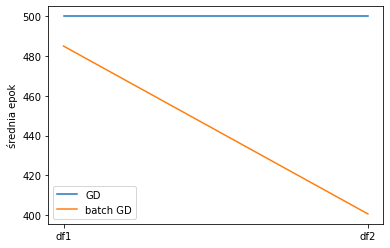

In [18]:
print("Architektura nr 1")
res_plot(r1)

Architektura nr 2


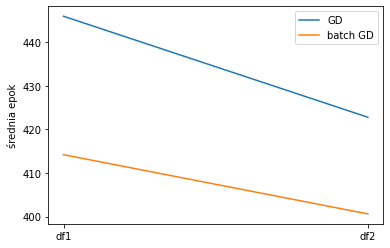

In [19]:
print("Architektura nr 2")
res_plot(r2)

Architektura nr 3


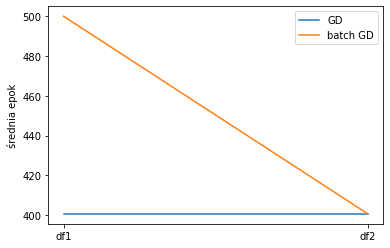

In [20]:
print("Architektura nr 3")
res_plot(r3)

### Wnioski

- algorytm batch Gradient Descent faktycznie potrzebuje mniejszej liczby epok do wytrenowania niż wersja pełna

## 2. Inicjalizacja wag
Porównam 3 rozkłady inicjujące wagi:

- U[-1, 1]
- U[0, 1]
- U[-2, 2]

### Obliczenia

In [50]:
r1 = np.zeros((2, 3))
r2 = np.zeros((2, 3))
r3 = np.zeros((2, 3))
j = 0
for df_train, df_test in zip(data_train[0:2], data_test[0:2]):
    x_train, y_train, x_test, y_test = prepear_data(df_train, df_test)
    #Wykonam po n procesów trenowania sieci i uśrednię MSE
    n = 5
    ep1 = np.zeros((n, 3))
    ep2 = np.zeros((n, 3))
    ep3 = np.zeros((n, 3))
    
    for i in range(n):
        #Architektura 1
        mlp1 = arch1()
        mlp2 = arch1(lb = 0, ub = 1)
        mlp3 = arch1(lb = -2, ub = 2)
        
        mlp1.train(x_train, y_train)
        mlp2.train(x_train, y_train)
        mlp3.train(x_train, y_train)
        
        ep1[i][0] = MSE(mlp1.predict(x_test), y_test)
        ep1[i][1] = MSE(mlp2.predict(x_test), y_test)
        ep1[i][2] = MSE(mlp3.predict(x_test), y_test)
        
        #Architektura 2
        mlp1 = arch2()
        mlp2 = arch2(lb = 0, ub = 1)
        mlp3 = arch2(lb = -2, ub = 2)
        
        mlp1.train(x_train, y_train)
        mlp2.train(x_train, y_train)
        mlp3.train(x_train, y_train)
        
        ep2[i][0] = MSE(mlp1.predict(x_test), y_test)
        ep2[i][1] = MSE(mlp2.predict(x_test), y_test)
        ep2[i][2] = MSE(mlp3.predict(x_test), y_test)
        
        #Architektura 3
        mlp1 = arch3()
        mlp2 = arch3(lb = 0, ub = 1)
        mlp3 = arch3(lb = -2, ub = 2)
        
        mlp1.train(x_train, y_train)
        mlp2.train(x_train, y_train)
        mlp3.train(x_train, y_train)
        
        ep3[i][0] = MSE(mlp1.predict(x_test), y_test)
        ep3[i][1] = MSE(mlp2.predict(x_test), y_test)
        ep3[i][2] = MSE(mlp3.predict(x_test), y_test)
        
    r1[j] = np.mean(ep1, axis=0)
    r2[j] = np.mean(ep2, axis=0)
    r3[j] = np.mean(ep3, axis=0)
    j+=1
    print("DF " + str(j) + " finished")        

DF 1 finished
DF 2 finished


In [51]:
def res_plot2(r):
    plt.plot(["df1", "df2"], r.transpose()[0], label = "U[-1, 1]")
    plt.plot(r.transpose()[1], label = "U[0, 1]")
    plt.plot(r.transpose()[2], label = "U[-2, 2]")
    plt.legend()
    plt.ylabel("średnie MSE")

### Wyniki

- wykresy przedstawiają średnie MSE osiągnięte na danym zbiorze (wyliczone na predykcji części testowej) z kilku prób, w zależności od rozkładu losowego inicjalizacji wag

### Architektura 1

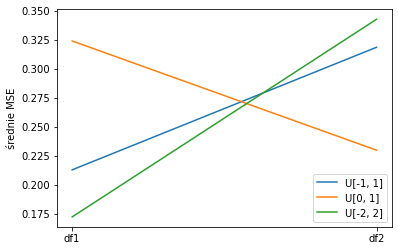

In [52]:
res_plot2(r1)

### Architektura 2

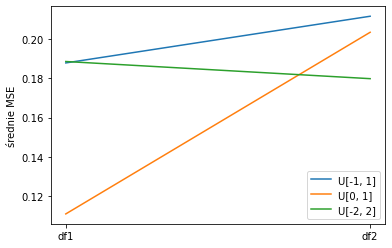

In [53]:
res_plot2(r2)

### Architektura 3

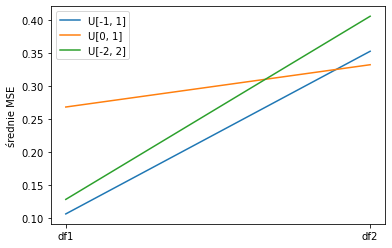

In [54]:
res_plot2(r3)

### Wnioski

- inicjalizacja parametrów ma istotny wpływ na jakość uczenia
- trudno jednoznacznie określić, który rozkład okazał się najlepszy, potrzebne byłoby przeprowadzenie większego eksperymentu